# Unsupervised Learning applied to Customer Lifetime Value (CLV)

![](https://wilsonprintingusa.com/wp-content/uploads/2015/02/Customer-Lifetime-Value-Wilson-Printing.jpg)

# Prepare Workspace

In [1]:
# Upload libraries
from numpy.random import seed
seed(1)
import tensorflow.keras
tensorflow.random.set_seed(2)

# to handle datasets
import numpy as np
import pandas as pd
import datetime

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# for statistics
import statistics as st 
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# to split data set 
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# to build models
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# dimensionality reductiion
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
from keras.layers import Input,Dense
from keras.models import Model

# clustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# to evaluate models
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('AutoInsurance.csv')

# Data set Overview

In [3]:
# Dimensions of data set
print(df.shape)

(9134, 24)


In [4]:
# List types for each attribute
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   object 
 1   State                          9134 non-null   object 
 2   Customer Lifetime Value        9134 non-null   float64
 3   Response                       9134 non-null   object 
 4   Coverage                       9134 non-null   object 
 5   Education                      9134 non-null   object 
 6   Effective To Date              9134 non-null   object 
 7   EmploymentStatus               9134 non-null   object 
 8   Gender                         9134 non-null   object 
 9   Income                         9134 non-null   int64  
 10  Location Code                  9134 non-null   object 
 11  Marital Status                 9134 non-null   object 
 12  Monthly Premium Auto           9134 non-null   i

In [5]:
# Take a peek at the first rows of the data
df.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,3/2/2011,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


# Data Cleaning & Handling Variables Activity

In [6]:
# Change format Date
df_1 = df.copy()
df_1['Effective_Date'] = pd.to_datetime(df_1['Effective To Date'])

### Handling Missing Values

In [7]:
# Check missing values both to numeric features and categorical features 
missing = df_1.isnull().sum()/df_1.shape[0]*100
missing

Customer                         0.0
State                            0.0
Customer Lifetime Value          0.0
Response                         0.0
Coverage                         0.0
Education                        0.0
Effective To Date                0.0
EmploymentStatus                 0.0
Gender                           0.0
Income                           0.0
Location Code                    0.0
Marital Status                   0.0
Monthly Premium Auto             0.0
Months Since Last Claim          0.0
Months Since Policy Inception    0.0
Number of Open Complaints        0.0
Number of Policies               0.0
Policy Type                      0.0
Policy                           0.0
Renew Offer Type                 0.0
Sales Channel                    0.0
Total Claim Amount               0.0
Vehicle Class                    0.0
Vehicle Size                     0.0
Effective_Date                   0.0
dtype: float64

In [8]:
# Min Value Effective to Date Policy
df_1['Effective_Date'].min()

Timestamp('2011-01-01 00:00:00')

In [9]:
# Max Value Effective to Date Policy
df_1['Effective_Date'].max()

Timestamp('2011-12-02 00:00:00')

In [10]:
# End of Year (eoy) of the current Effective to Date
df_1['eoy_Effective_Date'] = pd.to_datetime('2011-12-31')

In [11]:
# Days missing to the end of the current year from effective to date
df_1['eoy_missing_days'] = (df_1['eoy_Effective_Date'] - df_1['Effective_Date']).dt.days

In [12]:
# check duplicates
df_1_duplicates = df_1[df_1.duplicated(['Customer'])]

In [13]:
df_1_duplicates

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size,Effective_Date,eoy_Effective_Date,eoy_missing_days


In [14]:
df_1 = df_1.drop(['Customer','Effective To Date','eoy_Effective_Date'], axis=1)

In [15]:
# Rename some features for a practical use
df_new = df_1.copy()
df_new = df_new.rename(columns={"Customer Lifetime Value":"Customer_Lifetime_Value","Location Code":"Location_Code","Marital Status":"Marital_Status","Monthly Premium Auto":"Monthly_Premium_Auto","Months Since Last Claim":"Months_Since_Last_Claim",
                           "Months Since Policy Inception":"Months_Since_Policy_Inception","Number of Open Complaints":"Number_of_Open_Complaints","Number of Policies":"Number_of_Policies",
                           "Policy Type":"Policy_Type","Renew Offer Type":"Renew_Offer_Type","Sales Channel":"Sales_Channel","Total Claim Amount":"Total_Claim_Amount",
                           "Vehicle Class":"Vehicle_Class","Vehicle Size":"Vehicle_Size"})

# Summary Statistics

In [16]:
# Summarize attribute distributions for data type of variables
obj_cols = [var for var in df_new.columns if df_new[var].dtype=='object']
df_new[obj_cols].describe().T

,count,unique,top,freq
State,9134,5,California,3150
Response,9134,2,No,7826
Coverage,9134,3,Basic,5568
Education,9134,5,Bachelor,2748
EmploymentStatus,9134,5,Employed,5698
Gender,9134,2,F,4658
Location_Code,9134,3,Suburban,5779
Marital_Status,9134,3,Married,5298
Policy_Type,9134,3,Personal Auto,6788
Policy,9134,9,Personal L3,3426


In [17]:
# Summarize attribute distributions for data type of variables
no_obj_cols = [var for var in df_new.columns if df_new[var].dtype!='object']
df_new[no_obj_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Customer_Lifetime_Value,9134.0,8004.940475,6870.967608,1898.007675,3994.251794,5780.182197,8962.167041,83325.381190
Income,9134.0,37657.380009,30379.904734,0.000000,0.000000,33889.500000,62320.000000,99981.000000
Monthly_Premium_Auto,9134.0,93.219291,34.407967,61.000000,68.000000,83.000000,109.000000,298.000000
Months_Since_Last_Claim,9134.0,15.097000,10.073257,0.000000,6.000000,14.000000,23.000000,35.000000
Months_Since_Policy_Inception,9134.0,48.064594,27.905991,0.000000,24.000000,48.000000,71.000000,99.000000
Number_of_Open_Complaints,9134.0,0.384388,0.910384,0.000000,0.000000,0.000000,0.000000,5.000000
Number_of_Policies,9134.0,2.966170,2.390182,1.000000,1.000000,2.000000,4.000000,9.000000
Total_Claim_Amount,9134.0,434.088794,290.500092,0.099007,272.258244,383.945434,547.514839,2893.239678
eoy_missing_days,9134.0,276.667068,93.820412,29.000000,244.000000,315.000000,340.000000,364.000000


In [18]:
# Split data set between target variable and features
X_full = df_new.copy()
y = X_full.Customer_Lifetime_Value
X_full.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)

In [19]:
# Select numerical columns
numerical_cols = [cname for cname in X_full.columns if 
                X_full[cname].dtype in ['float64','int64']]

In [20]:
# Subset with numerical features
num = X_full[numerical_cols]
num.columns

Index(['Income', 'Monthly_Premium_Auto', 'Months_Since_Last_Claim',
       'Months_Since_Policy_Inception', 'Number_of_Open_Complaints',
       'Number_of_Policies', 'Total_Claim_Amount', 'eoy_missing_days'],
      dtype='object')

In [21]:
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_full.columns if
                    X_full[cname].nunique() <= 15 and 
                    X_full[cname].dtype == "object"]

In [22]:
# Subset with categorical features
cat = X_full[categorical_cols]
cat.columns


Index(['State', 'Response', 'Coverage', 'Education', 'EmploymentStatus',
       'Gender', 'Location_Code', 'Marital_Status', 'Policy_Type', 'Policy',
       'Renew_Offer_Type', 'Sales_Channel', 'Vehicle_Class', 'Vehicle_Size'],
      dtype='object')

# Pre-Processing on all data set

### One-Hot Encoding into k-1 dummy variables

In [23]:
# Encode the categorical data 
dummy_cat = pd.concat([pd.get_dummies(cat.State, prefix='State',drop_first=True), 
                       pd.get_dummies(cat.Coverage, prefix= 'Coverage', drop_first=True), 
                       pd.get_dummies(cat.Response, prefix= 'Response', drop_first=True),
                       pd.get_dummies(cat.Education, prefix='Education',drop_first=True),
                       pd.get_dummies(cat.EmploymentStatus, prefix='EmploymentStatus',drop_first=True),
                       pd.get_dummies(cat.Gender, prefix='Gender',drop_first=True),
                       pd.get_dummies(cat.Location_Code, prefix='Location_Code',drop_first=True),
                       pd.get_dummies(cat.Marital_Status, prefix='Marital_Status',drop_first=True),
                       pd.get_dummies(cat.Policy_Type, prefix='Policy_Type',drop_first=True),
                       pd.get_dummies(cat.Policy, prefix='Policy',drop_first=True),
                       pd.get_dummies(cat.Renew_Offer_Type, prefix='Renew_Offer_Type',drop_first=True),
                       pd.get_dummies(cat.Sales_Channel, prefix='Sales_Channel',drop_first=True),
                       pd.get_dummies(cat.Vehicle_Size, prefix='Vehicle_Size',drop_first=True),
                       pd.get_dummies(cat.Vehicle_Class, prefix='Vehicle_Class',drop_first=True)], axis=1)
dummy_cat = dummy_cat.astype(int)

In [24]:
# Grasp all
X_all = pd.concat([dummy_cat, num], axis=1)

### Zero/Close Zero Variance Predictors

In [25]:
# Find features with variance equal zero or lower than 0.05
to_drop = [col for col in X_all.columns if np.var(X_all[col]) < 0.05]
to_drop

['Education_Doctor',
 'EmploymentStatus_Medical Leave',
 'EmploymentStatus_Retired',
 'Policy_Type_Special Auto',
 'Policy_Special L1',
 'Policy_Special L2',
 'Policy_Special L3',
 'Vehicle_Class_Luxury Car',
 'Vehicle_Class_Luxury SUV']

In [26]:
# Drop features 
X_all = X_all.drop(X_all[to_drop], axis=1)

In [27]:
# Look at the new data set
X_all.shape

(9134, 42)

### Correlated Predictors

In [28]:
# Correlation heatmap
corr_matrix = X_all.corr()

In [29]:
# Select correlated features and removed it
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column].abs() > 0.75)]
to_drop

['EmploymentStatus_Unemployed', 'Vehicle_Size_Small', 'Income']

In [30]:
# Drop features 
X_all = X_all.drop(X_all[to_drop], axis=1)

In [31]:
# Look at the new data set
X_all.shape

(9134, 39)

# Flat Modeling & Prediction 

In [32]:
# Normalization of data
scaling = MinMaxScaler()

In [33]:
all = pd.concat([df_new[['Customer_Lifetime_Value','Effective_Date']], X_all], axis=1)

In [34]:
# Split data set train/test set:test set is built on the last 3 months to the end of the year 
train = all[all['Effective_Date'] <= '2011-09-30']
test = all[all['Effective_Date'] >= '2011-10-01']
train['month'] = pd.DatetimeIndex(train['Effective_Date']).month
test['month'] = pd.DatetimeIndex(test['Effective_Date']).month
train = train.drop(['Effective_Date'], axis=1)
test = test.drop(['Effective_Date'], axis=1)


In [35]:
# Create a month list 
month = test['month'].tolist()

# Subsetting
def subtable(test,month):
    return (test[(test['month'] == month)])

# Subsetting test
test_1 = subtable(test, 10)
test_2 = subtable(test, 11)
test_3 = subtable(test, 12)


In [36]:
# 10-2011
X_train = train.copy()
y_train = X_train.Customer_Lifetime_Value
X_train.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_train_sc = scaling.fit_transform(X_train)
X_test = test_1.copy()
y_test = X_test.Customer_Lifetime_Value
X_test.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_test_sc = scaling.transform(X_test)
month = '10-2011'
model = GradientBoostingRegressor(random_state=0)
kf = KFold(n_splits=5)
param_grid = {}
score = []
my_model = GridSearchCV(model,param_grid,cv=kf)
my_model.fit(X_train_sc, y_train)
predictions_tr = my_model.predict(X_train_sc) 
predictions_te = my_model.predict(X_test_sc)
CLV_predict = predictions_te
rmse_train = np.sqrt(mean_squared_error(y_train, predictions_tr))
rmse_test = np.sqrt(mean_squared_error(y_test, predictions_te))
score_dict = {
        'month': month,
        'rmse_train': rmse_train,
        'rmse_test': rmse_test
    }
score.append(score_dict)
score_1 = pd.DataFrame(score, columns = ['month','rmse_train', 'rmse_test'])
predictions_te_1 = pd.DataFrame(predictions_te, columns = ['Customer_Lifetime_Value_predict_flat'])
X_test = X_test.reset_index(drop=True)
pred_1 = pd.concat([predictions_te_1, X_test], axis=1)


In [37]:
# 11-2011
X_train = train.copy()
X_train = X_train.append(test_1)
y_train = X_train.Customer_Lifetime_Value
X_train.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_train_sc = scaling.fit_transform(X_train)
X_test = test_2.copy()
y_test = X_test.Customer_Lifetime_Value
X_test.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_test_sc = scaling.transform(X_test)
month = '11-2011'
model = GradientBoostingRegressor(random_state=0)
kf = KFold(n_splits=5)
param_grid = {}
score = []
my_model = GridSearchCV(model,param_grid,cv=kf)
my_model.fit(X_train_sc, y_train)
predictions_tr = my_model.predict(X_train_sc) 
predictions_te = my_model.predict(X_test_sc)
CLV_predict = predictions_te
rmse_train = np.sqrt(mean_squared_error(y_train, predictions_tr))
rmse_test = np.sqrt(mean_squared_error(y_test, predictions_te))
score_dict = {
        'month': month,
        'rmse_train': rmse_train,
        'rmse_test': rmse_test
    }
score.append(score_dict)
score_2 = pd.DataFrame(score, columns = ['month','rmse_train', 'rmse_test'])
predictions_te_2 = pd.DataFrame(predictions_te, columns = ['Customer_Lifetime_Value_predict_flat'])
X_test = X_test.reset_index(drop=True)
pred_2 = pd.concat([predictions_te_2, X_test], axis=1)


In [38]:
# 12-2011
X_train = train.copy()
X_train = X_train.append([test_1,test_2])
y_train = X_train.Customer_Lifetime_Value
X_train.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_train_sc = scaling.fit_transform(X_train)
X_test = test_3.copy()
y_test = X_test.Customer_Lifetime_Value
X_test.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_test_sc = scaling.transform(X_test)
month = '12-2011'
model = GradientBoostingRegressor(random_state=0)
kf = KFold(n_splits=5)
param_grid = {}
score = []
my_model = GridSearchCV(model,param_grid,cv=kf)
my_model.fit(X_train_sc, y_train)
predictions_tr = my_model.predict(X_train_sc) 
predictions_te = my_model.predict(X_test_sc)
CLV_predict = predictions_te
rmse_train = np.sqrt(mean_squared_error(y_train, predictions_tr))
rmse_test = np.sqrt(mean_squared_error(y_test, predictions_te))
score_dict = {
        'month': month,
        'rmse_train': rmse_train,
        'rmse_test': rmse_test
    }
score.append(score_dict)
score_3 = pd.DataFrame(score, columns = ['month','rmse_train', 'rmse_test'])
predictions_te_3 = pd.DataFrame(predictions_te, columns = ['Customer_Lifetime_Value_predict_flat'])
X_test = X_test.reset_index(drop=True)
pred_3 = pd.concat([predictions_te_3, X_test], axis=1)


### Results Analysis

In [39]:
predictions_te_flat = pd.concat([predictions_te_1,predictions_te_2,predictions_te_3], axis=0)
score_3M = pd.concat([score_1,score_2,score_3], axis=0)
score_3M

,month,rmse_train,rmse_test
0,10-2011,3593.681589,3418.440886
0,11-2011,3578.621512,3852.067561
0,12-2011,3585.853826,3760.876350


In [40]:
score_3M['rmse_train'].mean()

3586.0523091635673

In [41]:
score_3M['rmse_test'].mean()

3677.128265526158

In [42]:
test_df = all[all['Effective_Date'] >= '2011-10-01']
test_df = pd.concat([test_df, predictions_te_flat.set_index(test.index)], axis=1)
test_2 = df_new[df_new['Effective_Date'] >= '2011-10-01']
test_2_df = pd.concat([test_2, predictions_te_flat.set_index(test.index)], axis=1)

# PCA Modeling & Prediction 

In [43]:
# Normalization of data
X_all_sc = scaling.fit_transform(X_all)

In [44]:
X_all_sc_df = pd.DataFrame(X_all_sc, columns = X_all.columns)

In [45]:
pca = PCA(0.90, random_state=0)

In [46]:
pca_X_all_sc = pca.fit_transform(X_all_sc)

In [47]:
pca.n_components_

26

In [48]:
pca_df = pd.DataFrame(data = pca_X_all_sc, columns = ['pca'+str(i) for i in range(pca_X_all_sc.shape[1])])

In [49]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.0912326  0.06326121 0.05609743 0.05492208 0.05019354 0.04777269
 0.04621492 0.0445933  0.04257213 0.03865817 0.03812046 0.03461229
 0.02965867 0.02847749 0.02781658 0.02675401 0.0244996  0.02383272
 0.0219871  0.02067886 0.01659364 0.01616627 0.01540152 0.01513005
 0.01461322 0.01413997]


In [50]:
X_all_pca = pd.concat([pca_df, X_all], axis = 1)

In [51]:
# Check correlation with new features 
corr_matrix_pca = X_all_pca.corr()

In [52]:
# Select correlated features and removed it
# Select upper triangle of correlation matrix
upper = corr_matrix_pca.where(np.triu(np.ones(corr_matrix_pca.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column].abs() > 0.75)]
to_drop

['State_California',
 'Coverage_Extended',
 'Response_Yes',
 'Gender_M',
 'Policy_Type_Personal Auto',
 'Policy_Personal L1',
 'Policy_Personal L2',
 'Policy_Personal L3',
 'Renew_Offer_Type_Offer2',
 'Renew_Offer_Type_Offer3',
 'Sales_Channel_Branch',
 'Sales_Channel_Web',
 'Months_Since_Last_Claim',
 'eoy_missing_days']

In [53]:
pca_X = X_all_pca.drop(X_all_pca[to_drop], axis=1)

In [54]:
pca_X.shape

(9134, 51)

In [55]:
all_pca = pd.concat([df_new[['Customer_Lifetime_Value','Effective_Date']], pca_X], axis=1)

In [56]:
# Split data set train/test set:test set is built on the last 3 months to the end of the year 
train = all_pca[all_pca['Effective_Date'] <= '2011-09-30']
test = all_pca[all_pca['Effective_Date'] >= '2011-10-01']
train['month'] = pd.DatetimeIndex(train['Effective_Date']).month
test['month'] = pd.DatetimeIndex(test['Effective_Date']).month
train = train.drop(['Effective_Date'], axis=1)
test = test.drop(['Effective_Date'], axis=1)

In [57]:
# Create a month list 
month = test['month'].tolist()

# Subsetting
def subtable(test,month):
    return (test[(test['month'] == month)])

# Subsetting test
test_1 = subtable(test, 10)
test_2 = subtable(test, 11)
test_3 = subtable(test, 12)

In [58]:
# 10-2011
X_train = train.copy()
y_train = X_train.Customer_Lifetime_Value
X_train.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_train_sc = scaling.fit_transform(X_train)
X_test = test_1.copy()
y_test = X_test.Customer_Lifetime_Value
X_test.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_test_sc = scaling.transform(X_test)
month = '10-2011'
model = GradientBoostingRegressor(random_state=0)
kf = KFold(n_splits=5)
param_grid = {}
score = []
my_model = GridSearchCV(model,param_grid,cv=kf)
my_model.fit(X_train_sc, y_train)
predictions_tr = my_model.predict(X_train_sc) 
predictions_te = my_model.predict(X_test_sc)
CLV_predict = predictions_te
rmse_train = np.sqrt(mean_squared_error(y_train, predictions_tr))
rmse_test = np.sqrt(mean_squared_error(y_test, predictions_te))
score_dict = {
        'month': month,
        'rmse_train': rmse_train,
        'rmse_test': rmse_test
    }
score.append(score_dict)
score_1 = pd.DataFrame(score, columns = ['month','rmse_train', 'rmse_test'])
predictions_te_1 = pd.DataFrame(predictions_te, columns = ['Customer_Lifetime_Value_predict_pca'])
X_test = X_test.reset_index(drop=True)
pred_1 = pd.concat([predictions_te_1, X_test], axis=1)


In [59]:
# 11-2011
X_train = train.copy()
X_train = X_train.append(test_1)
y_train = X_train.Customer_Lifetime_Value
X_train.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_train_sc = scaling.fit_transform(X_train)
X_test = test_2.copy()
y_test = X_test.Customer_Lifetime_Value
X_test.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_test_sc = scaling.transform(X_test)
month = '11-2011'
model = GradientBoostingRegressor(random_state=0)
kf = KFold(n_splits=5)
param_grid = {}
score = []
my_model = GridSearchCV(model,param_grid,cv=kf)
my_model.fit(X_train_sc, y_train)
predictions_tr = my_model.predict(X_train_sc) 
predictions_te = my_model.predict(X_test_sc)
CLV_predict = predictions_te
rmse_train = np.sqrt(mean_squared_error(y_train, predictions_tr))
rmse_test = np.sqrt(mean_squared_error(y_test, predictions_te))
score_dict = {
        'month': month,
        'rmse_train': rmse_train,
        'rmse_test': rmse_test
    }
score.append(score_dict)
score_2 = pd.DataFrame(score, columns = ['month','rmse_train', 'rmse_test'])
predictions_te_2 = pd.DataFrame(predictions_te, columns = ['Customer_Lifetime_Value_predict_pca'])
X_test = X_test.reset_index(drop=True)
pred_2 = pd.concat([predictions_te_2, X_test], axis=1)


In [60]:
# 12-2011
X_train = train.copy()
X_train = X_train.append([test_1,test_2])
y_train = X_train.Customer_Lifetime_Value
X_train.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_train_sc = scaling.fit_transform(X_train)
X_test = test_3.copy()
y_test = X_test.Customer_Lifetime_Value
X_test.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_test_sc = scaling.transform(X_test)
month = '12-2011'
model = GradientBoostingRegressor(random_state=0)
kf = KFold(n_splits=5)
param_grid = {}
score = []
my_model = GridSearchCV(model,param_grid,cv=kf)
my_model.fit(X_train_sc, y_train)
predictions_tr = my_model.predict(X_train_sc) 
predictions_te = my_model.predict(X_test_sc)
CLV_predict = predictions_te
rmse_train = np.sqrt(mean_squared_error(y_train, predictions_tr))
rmse_test = np.sqrt(mean_squared_error(y_test, predictions_te))
score_dict = {
        'month': month,
        'rmse_train': rmse_train,
        'rmse_test': rmse_test
    }
score.append(score_dict)
score_3 = pd.DataFrame(score, columns = ['month','rmse_train', 'rmse_test'])
predictions_te_3 = pd.DataFrame(predictions_te, columns = ['Customer_Lifetime_Value_predict_pca'])
X_test = X_test.reset_index(drop=True)
pred_3 = pd.concat([predictions_te_3, X_test], axis=1)


### Results Analysis

In [61]:
predictions_te_pca = pd.concat([predictions_te_1,predictions_te_2,predictions_te_3], axis=0)
score_3M = pd.concat([score_1,score_2,score_3], axis=0)
score_3M

,month,rmse_train,rmse_test
0,10-2011,3515.992463,3358.350404
0,11-2011,3498.921037,3880.596256
0,12-2011,3503.359266,3745.487309


In [62]:
score_3M['rmse_train'].mean()

3506.0909218730776

In [63]:
score_3M['rmse_test'].mean()

3661.477989728973

In [64]:
test_df = all[all['Effective_Date'] >= '2011-10-01']
test_df = pd.concat([test_df, predictions_te_flat.set_index(test.index), predictions_te_pca.set_index(test.index)], axis=1)
test_2 = df_new[df_new['Effective_Date'] >= '2011-10-01']
test_2_df = pd.concat([test_2, predictions_te_flat.set_index(test.index), predictions_te_pca.set_index(test.index)], axis=1)

# Autoencoders Modeling & Prediction

In [65]:
# https://blog.keras.io/building-autoencoders-in-keras.html
# single fully-connected neural layer as encoder and as decoder
# This is the size of our encoded representations
encoding_dim = 26  

# This is our input 
input_data = Input(shape=(39,)) # 39 is the number of features/columns
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_data)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(39, activation='relu')(encoded)

# This model maps an input to its reconstruction
autoencoder = Model(input_data, decoded)

In [66]:
# create a separate encoder model:
# This model maps an input to its encoded representation
encoder = Model(input_data, encoded)
# create a separate decoder model:
# This is our encoded (26-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [67]:
# Configure the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [68]:
# train the model
autoencoder.fit(X_all_sc,
                X_all_sc,
                epochs=50)

autoencoder.summary()

Epoch 1/50
286/286 [==============================] - 0s 805us/step - loss: 0.1219
Epoch 2/50
286/286 [==============================] - 0s 869us/step - loss: 0.0416
Epoch 3/50
286/286 [==============================] - 0s 825us/step - loss: 0.0201
Epoch 4/50
286/286 [==============================] - 0s 720us/step - loss: 0.0129
Epoch 5/50
286/286 [==============================] - 0s 748us/step - loss: 0.0100
Epoch 6/50
286/286 [==============================] - 0s 745us/step - loss: 0.0083
Epoch 7/50
286/286 [==============================] - 0s 741us/step - loss: 0.0071
Epoch 8/50
286/286 [==============================] - 0s 807us/step - loss: 0.0068
Epoch 9/50
286/286 [==============================] - 0s 716us/step - loss: 0.0066
Epoch 10/50
286/286 [==============================] - 0s 753us/step - loss: 0.0065
Epoch 11/50
286/286 [==============================] - 0s 767us/step - loss: 0.0065
Epoch 12/50
286/286 [==============================] - 0s 774us/step - loss: 0.0064
E

In [69]:
# predict after training
encoded_input = encoder.predict(X_all_sc)

In [70]:
autoencoder_df = pd.DataFrame(data = encoded_input, columns=['autoencoder'+str(i) for i in range(encoded_input.shape[1])])

In [71]:
X_all_autoencoder = pd.concat([autoencoder_df, X_all], axis = 1)

In [72]:
# Check correlation with new features 
corr_matrix_f = X_all_autoencoder.corr()

In [73]:
# Select correlated features and removed it
# Select upper triangle of correlation matrix
upper = corr_matrix_f.where(np.triu(np.ones(corr_matrix_f.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column].abs() > 0.75)]
to_drop

[]

In [74]:
autoencoder_X = X_all_autoencoder.drop(X_all_autoencoder[to_drop], axis=1)

In [75]:
autoencoder_X.shape

(9134, 65)

In [76]:
all_autoencoder = pd.concat([df_new[['Customer_Lifetime_Value','Effective_Date']], autoencoder_X], axis=1)

In [77]:
# Split data set train/test set:test set is built on the last 3 months to the end of the year 
train = all_autoencoder[all_autoencoder['Effective_Date'] <= '2011-09-30']
test = all_autoencoder[all_autoencoder['Effective_Date'] >= '2011-10-01']
train['month'] = pd.DatetimeIndex(train['Effective_Date']).month
test['month'] = pd.DatetimeIndex(test['Effective_Date']).month
train = train.drop(['Effective_Date'], axis=1)
test = test.drop(['Effective_Date'], axis=1)

In [78]:
# Create a month list 
month = test['month'].tolist()

# Subsetting
def subtable(test,month):
    return (test[(test['month'] == month)])

# Subsetting test
test_1 = subtable(test, 10)
test_2 = subtable(test, 11)
test_3 = subtable(test, 12)

In [79]:
# 10-2011
X_train = train.copy()
y_train = X_train.Customer_Lifetime_Value
X_train.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_train_sc = scaling.fit_transform(X_train)
X_test = test_1.copy()
y_test = X_test.Customer_Lifetime_Value
X_test.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_test_sc = scaling.transform(X_test)
month = '10-2011'
model = GradientBoostingRegressor(random_state=0)
kf = KFold(n_splits=5)
param_grid = {}
score = []
my_model = GridSearchCV(model,param_grid,cv=kf)
my_model.fit(X_train_sc, y_train)
predictions_tr = my_model.predict(X_train_sc) 
predictions_te = my_model.predict(X_test_sc)
CLV_predict = predictions_te
rmse_train = np.sqrt(mean_squared_error(y_train, predictions_tr))
rmse_test = np.sqrt(mean_squared_error(y_test, predictions_te))
score_dict = {
        'month': month,
        'rmse_train': rmse_train,
        'rmse_test': rmse_test
    }
score.append(score_dict)
score_1 = pd.DataFrame(score, columns = ['month','rmse_train', 'rmse_test'])
predictions_te_1 = pd.DataFrame(predictions_te, columns = ['Customer_Lifetime_Value_predict_autoencoder'])
X_test = X_test.reset_index(drop=True)
pred_1 = pd.concat([predictions_te_1, X_test], axis=1)


In [80]:
# 11-2011
X_train = train.copy()
X_train = X_train.append(test_1)
y_train = X_train.Customer_Lifetime_Value
X_train.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_train_sc = scaling.fit_transform(X_train)
X_test = test_2.copy()
y_test = X_test.Customer_Lifetime_Value
X_test.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_test_sc = scaling.transform(X_test)
month = '11-2011'
model = GradientBoostingRegressor(random_state=0)
kf = KFold(n_splits=5)
param_grid = {}
score = []
my_model = GridSearchCV(model,param_grid,cv=kf)
my_model.fit(X_train_sc, y_train)
predictions_tr = my_model.predict(X_train_sc) 
predictions_te = my_model.predict(X_test_sc)
CLV_predict = predictions_te
rmse_train = np.sqrt(mean_squared_error(y_train, predictions_tr))
rmse_test = np.sqrt(mean_squared_error(y_test, predictions_te))
score_dict = {
        'month': month,
        'rmse_train': rmse_train,
        'rmse_test': rmse_test
    }
score.append(score_dict)
score_2 = pd.DataFrame(score, columns = ['month','rmse_train', 'rmse_test'])
predictions_te_2 = pd.DataFrame(predictions_te, columns = ['Customer_Lifetime_Value_predict_autoencoder'])
X_test = X_test.reset_index(drop=True)
pred_2 = pd.concat([predictions_te_2, X_test], axis=1)

In [81]:
# 12-2011
X_train = train.copy()
X_train = X_train.append([test_1,test_2])
y_train = X_train.Customer_Lifetime_Value
X_train.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_train_sc = scaling.fit_transform(X_train)
X_test = test_3.copy()
y_test = X_test.Customer_Lifetime_Value
X_test.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_test_sc = scaling.transform(X_test)
month = '12-2011'
model = GradientBoostingRegressor(random_state=0)
kf = KFold(n_splits=5)
param_grid = {}
score = []
my_model = GridSearchCV(model,param_grid,cv=kf)
my_model.fit(X_train_sc, y_train)
predictions_tr = my_model.predict(X_train_sc) 
predictions_te = my_model.predict(X_test_sc)
CLV_predict = predictions_te
rmse_train = np.sqrt(mean_squared_error(y_train, predictions_tr))
rmse_test = np.sqrt(mean_squared_error(y_test, predictions_te))
score_dict = {
        'month': month,
        'rmse_train': rmse_train,
        'rmse_test': rmse_test
    }
score.append(score_dict)
score_3 = pd.DataFrame(score, columns = ['month','rmse_train', 'rmse_test'])
predictions_te_3 = pd.DataFrame(predictions_te, columns = ['Customer_Lifetime_Value_predict_autoencoder'])
X_test = X_test.reset_index(drop=True)
pred_3 = pd.concat([predictions_te_3, X_test], axis=1)

### Results Analysis

In [82]:
predictions_te_autoencoder = pd.concat([predictions_te_1,predictions_te_2,predictions_te_3], axis=0)
score_3M = pd.concat([score_1,score_2,score_3], axis=0)
score_3M

,month,rmse_train,rmse_test
0,10-2011,3495.653953,3436.976966
0,11-2011,3499.894279,3760.601965
0,12-2011,3507.150066,3676.244756


In [83]:
score_3M['rmse_train'].mean()

3500.899432503012

In [84]:
score_3M['rmse_test'].mean()

3624.607895901376

In [85]:
test_df = all[all['Effective_Date'] >= '2011-10-01']
test_df = pd.concat([test_df, predictions_te_flat.set_index(test.index), 
                     predictions_te_pca.set_index(test.index), predictions_te_autoencoder.set_index(test.index)], axis=1)
test_2 = df_new[df_new['Effective_Date'] >= '2011-10-01']
test_2_df = pd.concat([test_2, predictions_te_flat.set_index(test.index), 
                     predictions_te_pca.set_index(test.index), predictions_te_autoencoder.set_index(test.index)], axis=1)

# Isomap Modeling & Prediction

In [86]:
np.random.seed(0)
isomap = Isomap(n_components=26)

In [87]:
isomap_embedd = isomap.fit_transform(X_all_sc)

In [88]:
isomap_embedd_df = pd.DataFrame(data = isomap_embedd, columns=['embedding'+str(i) for i in range(isomap_embedd.shape[1])])

In [89]:
X_all_isomap = pd.concat([isomap_embedd_df, X_all], axis = 1)

In [90]:
# Check correlation with new features 
corr_matrix_f = X_all_isomap.corr()

In [91]:
# Select correlated features and removed it
# Select upper triangle of correlation matrix
upper = corr_matrix_f.where(np.triu(np.ones(corr_matrix_f.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column].abs() > 0.75)]
to_drop

['Gender_M',
 'Policy_Type_Personal Auto',
 'Policy_Personal L1',
 'Policy_Personal L2',
 'Renew_Offer_Type_Offer2',
 'Sales_Channel_Branch']

In [92]:
isomap_X = X_all_isomap.drop(X_all_isomap[to_drop], axis=1)

In [93]:
isomap_X.shape

(9134, 59)

In [94]:
all_isomap = pd.concat([df_new[['Customer_Lifetime_Value','Effective_Date']], isomap_X], axis=1)

In [95]:
# Split data set train/test set:test set is built on the last 3 months to the end of the year 
train = all_isomap[all_isomap['Effective_Date'] <= '2011-09-30']
test = all_isomap[all_isomap['Effective_Date'] >= '2011-10-01']
train['month'] = pd.DatetimeIndex(train['Effective_Date']).month
test['month'] = pd.DatetimeIndex(test['Effective_Date']).month
train = train.drop(['Effective_Date'], axis=1)
test = test.drop(['Effective_Date'], axis=1)

In [96]:
# Create a month list 
month = test['month'].tolist()

# Subsetting
def subtable(test,month):
    return (test[(test['month'] == month)])

# Subsetting test
test_1 = subtable(test, 10)
test_2 = subtable(test, 11)
test_3 = subtable(test, 12)

In [97]:
# 10-2011
X_train = train.copy()
y_train = X_train.Customer_Lifetime_Value
X_train.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_train_sc = scaling.fit_transform(X_train)
X_test = test_1.copy()
y_test = X_test.Customer_Lifetime_Value
X_test.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_test_sc = scaling.transform(X_test)
month = '10-2011'
model = GradientBoostingRegressor(random_state=0)
kf = KFold(n_splits=5)
param_grid = {}
score = []
my_model = GridSearchCV(model,param_grid,cv=kf)
my_model.fit(X_train_sc, y_train)
predictions_tr = my_model.predict(X_train_sc) 
predictions_te = my_model.predict(X_test_sc)
CLV_predict = predictions_te
rmse_train = np.sqrt(mean_squared_error(y_train, predictions_tr))
rmse_test = np.sqrt(mean_squared_error(y_test, predictions_te))
score_dict = {
        'month': month,
        'rmse_train': rmse_train,
        'rmse_test': rmse_test
    }
score.append(score_dict)
score_1 = pd.DataFrame(score, columns = ['month','rmse_train', 'rmse_test'])
predictions_te_1 = pd.DataFrame(predictions_te, columns = ['Customer_Lifetime_Value_predict_isomap'])
X_test = X_test.reset_index(drop=True)
pred_1 = pd.concat([predictions_te_1, X_test], axis=1)

In [98]:
# 11-2011
X_train = train.copy()
X_train = X_train.append(test_1)
y_train = X_train.Customer_Lifetime_Value
X_train.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_train_sc = scaling.fit_transform(X_train)
X_test = test_2.copy()
y_test = X_test.Customer_Lifetime_Value
X_test.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_test_sc = scaling.transform(X_test)
month = '11-2011'
model = GradientBoostingRegressor(random_state=0)
kf = KFold(n_splits=5)
param_grid = {}
score = []
my_model = GridSearchCV(model,param_grid,cv=kf)
my_model.fit(X_train_sc, y_train)
predictions_tr = my_model.predict(X_train_sc) 
predictions_te = my_model.predict(X_test_sc)
CLV_predict = predictions_te
rmse_train = np.sqrt(mean_squared_error(y_train, predictions_tr))
rmse_test = np.sqrt(mean_squared_error(y_test, predictions_te))
score_dict = {
        'month': month,
        'rmse_train': rmse_train,
        'rmse_test': rmse_test
    }
score.append(score_dict)
score_2 = pd.DataFrame(score, columns = ['month','rmse_train', 'rmse_test'])
predictions_te_2 = pd.DataFrame(predictions_te, columns = ['Customer_Lifetime_Value_predict_isomap'])
X_test = X_test.reset_index(drop=True)
pred_2 = pd.concat([predictions_te_2, X_test], axis=1)

In [99]:
# 12-2011
X_train = train.copy()
X_train = X_train.append([test_1,test_2])
y_train = X_train.Customer_Lifetime_Value
X_train.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_train_sc = scaling.fit_transform(X_train)
X_test = test_3.copy()
y_test = X_test.Customer_Lifetime_Value
X_test.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_test_sc = scaling.transform(X_test)
month = '12-2011'
model = GradientBoostingRegressor(random_state=0)
kf = KFold(n_splits=5)
param_grid = {}
score = []
my_model = GridSearchCV(model,param_grid,cv=kf)
my_model.fit(X_train_sc, y_train)
predictions_tr = my_model.predict(X_train_sc) 
predictions_te = my_model.predict(X_test_sc)
CLV_predict = predictions_te
rmse_train = np.sqrt(mean_squared_error(y_train, predictions_tr))
rmse_test = np.sqrt(mean_squared_error(y_test, predictions_te))
score_dict = {
        'month': month,
        'rmse_train': rmse_train,
        'rmse_test': rmse_test
    }
score.append(score_dict)
score_3 = pd.DataFrame(score, columns = ['month','rmse_train', 'rmse_test'])
predictions_te_3 = pd.DataFrame(predictions_te, columns = ['Customer_Lifetime_Value_predict_isomap'])
X_test = X_test.reset_index(drop=True)
pred_3 = pd.concat([predictions_te_3, X_test], axis=1)

### Results Analysis

In [100]:
predictions_te_isomap = pd.concat([predictions_te_1,predictions_te_2,predictions_te_3], axis=0)
score_3M = pd.concat([score_1,score_2,score_3], axis=0)
score_3M

,month,rmse_train,rmse_test
0,10-2011,3507.910433,3370.639414
0,11-2011,3508.323564,3793.972739
0,12-2011,3502.578941,3718.968297


In [101]:
score_3M['rmse_train'].mean()

3506.2709792821734

In [102]:
score_3M['rmse_test'].mean()

3627.860149858168

In [103]:
test_df = all[all['Effective_Date'] >= '2011-10-01']
test_df = pd.concat([test_df, predictions_te_flat.set_index(test.index), predictions_te_pca.set_index(test.index), 
                     predictions_te_autoencoder.set_index(test.index), predictions_te_isomap.set_index(test.index)], axis=1)

test_2 = df_new[df_new['Effective_Date'] >= '2011-10-01']
test_2_df = pd.concat([test_2, predictions_te_flat.set_index(test.index), predictions_te_pca.set_index(test.index),
                      predictions_te_autoencoder.set_index(test.index), predictions_te_isomap.set_index(test.index)], axis=1)

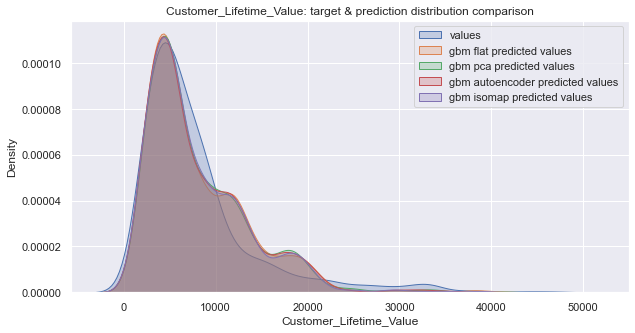

In [104]:
# Plot results
sns.set( rc = {'figure.figsize': (10, 5)})
fig,ax = plt.subplots(1, 1)
sns.kdeplot(x=test_df['Customer_Lifetime_Value'], fill=True, palette="crest", label="values",)
sns.kdeplot(x=test_df['Customer_Lifetime_Value_predict_flat'], fill=True, palette="crest", label='gbm flat predicted values')
sns.kdeplot(x=test_df['Customer_Lifetime_Value_predict_pca'], fill=True, palette="crest", label='gbm pca predicted values')
sns.kdeplot(x=test_df['Customer_Lifetime_Value_predict_autoencoder'], fill=True, palette="crest", label='gbm autoencoder predicted values')
sns.kdeplot(x=test_df['Customer_Lifetime_Value_predict_isomap'], fill=True, palette="crest", label='gbm isomap predicted values')
plt.title('Customer_Lifetime_Value: target & prediction distribution comparison')
ax.legend()
plt.show()

### Binning

In [105]:
binsize_c = 13

In [106]:
claim_range = test_df['Total_Claim_Amount'].max() - test_df['Total_Claim_Amount'].min()
claim_range

1723.3473039999997

In [107]:
# lower and upper boundaries
min_value_c = int(np.floor(test_df['Total_Claim_Amount'].min()))
max_value_c = int(np.floor(test_df['Total_Claim_Amount'].max()))
inter_value_c = int(np.round(claim_range / binsize_c))
min_value_c, max_value_c, inter_value_c

(0, 1724, 133)

In [108]:
# interval limits to generate the bins
intervals_c = [i for i in range(min_value_c, max_value_c+inter_value_c, inter_value_c)]
intervals_c

[0, 133, 266, 399, 532, 665, 798, 931, 1064, 1197, 1330, 1463, 1596, 1729]

In [109]:
# Total_Claim_Amount discretization
test_df['Total_Claim_Amount_binned'] = pd.cut(x=test_df['Total_Claim_Amount'],
                             bins=intervals_c,
                             include_lowest=True)

In [110]:
claim_binned = test_df.groupby('Total_Claim_Amount_binned')['Total_Claim_Amount'].count()
claim_binned

Total_Claim_Amount_binned
(-0.001, 133.0]     146
(133.0, 266.0]      104
(266.0, 399.0]      261
(399.0, 532.0]      193
(532.0, 665.0]      103
(665.0, 798.0]       51
(798.0, 931.0]       40
(931.0, 1064.0]      25
(1064.0, 1197.0]     12
(1197.0, 1330.0]      8
(1330.0, 1463.0]      9
(1463.0, 1596.0]      2
(1596.0, 1729.0]      1
Name: Total_Claim_Amount, dtype: int64

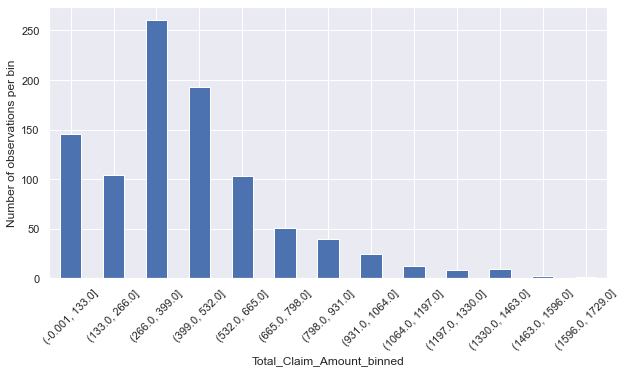

In [111]:
test_df.groupby('Total_Claim_Amount_binned')['Total_Claim_Amount'].count().plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Number of observations per bin')
plt.show()

### Results by grouping data

In [112]:
# group test on Total_Claim_Amount
test_df_group_claim = test_df.groupby(['Total_Claim_Amount_binned'])['Customer_Lifetime_Value','Customer_Lifetime_Value_predict_flat',
                                    'Customer_Lifetime_Value_predict_pca','Customer_Lifetime_Value_predict_autoencoder',
                                    'Customer_Lifetime_Value_predict_isomap'].sum().reset_index()

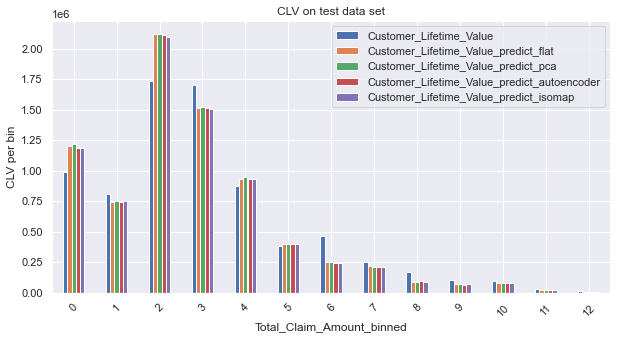

In [113]:
fig = plt.figsize=(30, 30)
test_df_group_claim.plot.bar()
plt.xticks(rotation=45)
plt.ylabel('CLV per bin')
plt.xlabel('Total_Claim_Amount_binned')
plt.title('CLV on test data set')
plt.show()

In [114]:
# group test on Monthly Premium Auto
test_df_group_premium = test_df.groupby(['Monthly_Premium_Auto'])['Customer_Lifetime_Value',
                        'Customer_Lifetime_Value_predict_flat', 'Customer_Lifetime_Value_predict_pca',
                        'Customer_Lifetime_Value_predict_autoencoder', 'Customer_Lifetime_Value_predict_isomap'].sum().reset_index()

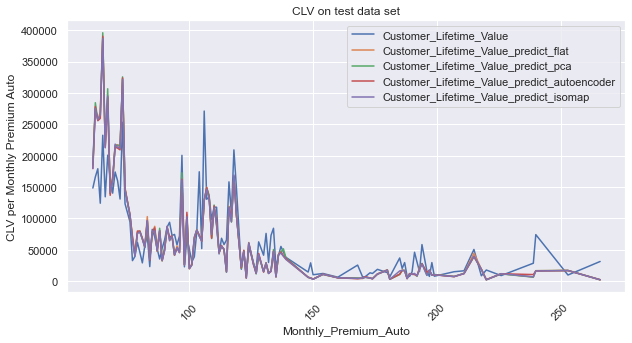

In [115]:
fig = plt.figsize=(20, 20)
test_df_group_premium.plot(x='Monthly_Premium_Auto', 
                           y=['Customer_Lifetime_Value','Customer_Lifetime_Value_predict_flat',
                            'Customer_Lifetime_Value_predict_pca', 'Customer_Lifetime_Value_predict_autoencoder',
                             'Customer_Lifetime_Value_predict_isomap'])
plt.ylabel('CLV per Monthly Premium Auto')
plt.xlabel('Monthly_Premium_Auto')
plt.title('CLV on test data set')
plt.xticks(rotation=45)
plt.show()

In [116]:
# group test on location_code
test_2_df_group_location = test_2_df.groupby(['Location_Code'])['Customer_Lifetime_Value',
                            'Customer_Lifetime_Value_predict_flat','Customer_Lifetime_Value_predict_pca',
                            'Customer_Lifetime_Value_predict_autoencoder','Customer_Lifetime_Value_predict_isomap'].sum().reset_index()

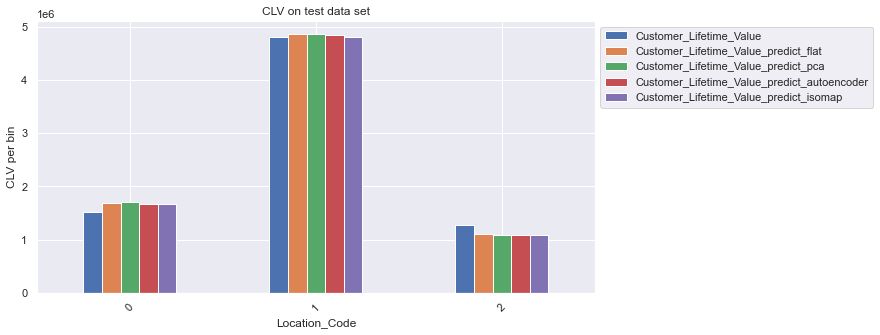

In [117]:
fig = plt.figsize=(20, 20)
test_2_df_group_location.plot.bar()
plt.xticks(rotation=45)
plt.ylabel('CLV per bin')
plt.xlabel('Location_Code')
plt.title('CLV on test data set')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

In [118]:
# group test on education
test_2_df_group_education = test_2_df.groupby(['Education'])['Customer_Lifetime_Value',
                            'Customer_Lifetime_Value_predict_flat','Customer_Lifetime_Value_predict_pca',
                            'Customer_Lifetime_Value_predict_autoencoder','Customer_Lifetime_Value_predict_isomap'].sum().reset_index()

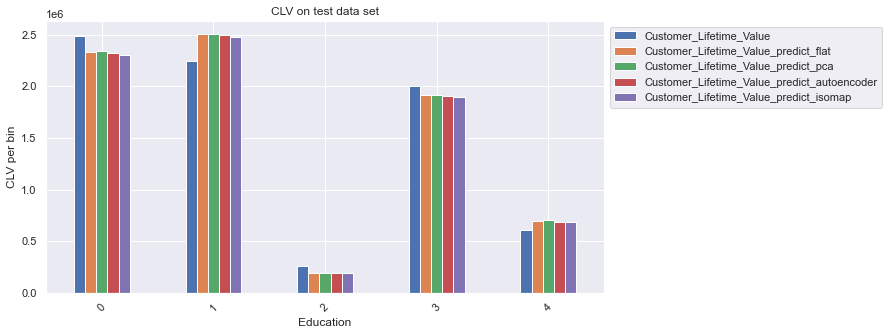

In [119]:
fig = plt.figsize=(20, 20)
test_2_df_group_education.plot.bar()
plt.xticks(rotation=45)
plt.ylabel('CLV per bin')
plt.xlabel('Education')
plt.title('CLV on test data set')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()